# Vision Transformer (ViT)

Lecture 11 | CMU ANLP Spring 2026 | Instructor: Sean Welleck

Understanding how Vision Transformers process images.

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests

from transformers import ViTModel, ViTImageProcessor, ViTForImageClassification

# Load model and processor
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)

print(f"Model: {model_name}")
print(f"Patch size: {model.config.patch_size}x{model.config.patch_size}")
print(f"Image size: {model.config.image_size}x{model.config.image_size}")
print(f"Hidden size: {model.config.hidden_size}")

/opt/miniconda3/envs/anlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: google/vit-base-patch16-224
Patch size: 16x16
Image size: 224x224
Hidden size: 768


## Load Image

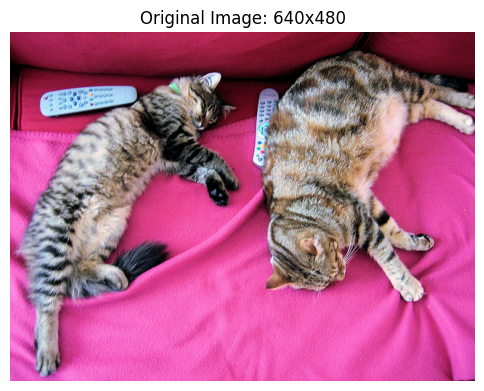

In [2]:
# Load sample image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display original
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Original Image: {image.size[0]}x{image.size[1]}")
plt.axis('off')
plt.show()

## Image to Patches

In [3]:
# Process image
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values']

# Calculate patch dimensions
patch_size = model.config.patch_size
image_size = model.config.image_size
num_patches_per_dim = image_size // patch_size
total_patches = num_patches_per_dim ** 2

print(f"Image size: {image_size}x{image_size}")
print(f"Patch size: {patch_size}x{patch_size}")
print(f"Patches per dimension: {num_patches_per_dim}")
print(f"Total patches: {total_patches}")
print(f"\nInput tensor shape: {pixel_values.shape}")
print(f"  [batch_size, channels, height, width]")

Image size: 224x224
Patch size: 16x16
Patches per dimension: 14
Total patches: 196

Input tensor shape: torch.Size([1, 3, 224, 224])
  [batch_size, channels, height, width]


## Patch Grid Visualization

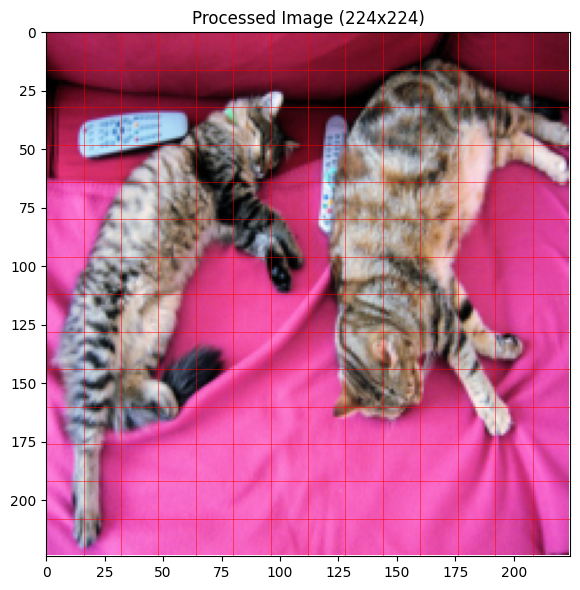

In [5]:
# Visualize patch grid
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

# Processed image with grid
processed_img = processor(images=image, return_tensors="np")['pixel_values'][0]
processed_img = np.transpose(processed_img, (1, 2, 0))
processed_img = (processed_img - processed_img.min()) / (processed_img.max() - processed_img.min())

ax1.imshow(processed_img)
ax1.set_title(f"Processed Image ({image_size}x{image_size})")

# Draw patch grid
for i in range(0, image_size, patch_size):
    ax1.axhline(y=i, color='red', linewidth=0.5, alpha=0.7)
    ax1.axvline(x=i, color='red', linewidth=0.5, alpha=0.7)

ax1.set_xlim(0, image_size)
ax1.set_ylim(image_size, 0)

plt.tight_layout()
plt.show()

## Patch Embeddings

In [7]:
with torch.no_grad():
    patch_embeddings = model.embeddings.patch_embeddings(pixel_values)
    
print("Patch embedding process:")
print(f"1. Input image: {pixel_values.shape}")
print(f"   [batch, channels={pixel_values.shape[1]}, height={pixel_values.shape[2]}, width={pixel_values.shape[3]}]")
print(f"\n2. After patch projection: {patch_embeddings.shape}")
print(f"   [batch, num_patches={patch_embeddings.shape[1]}, hidden_size={patch_embeddings.shape[2]}]")
print(f"\n3. Each {patch_size}x{patch_size}x3 patch → {model.config.hidden_size}-dim vector")

Patch embedding process:
1. Input image: torch.Size([1, 3, 224, 224])
   [batch, channels=3, height=224, width=224]

2. After patch projection: torch.Size([1, 196, 768])
   [batch, num_patches=196, hidden_size=768]

3. Each 16x16x3 patch → 768-dim vector


## CLS Token and Position Embeddings

In [8]:
with torch.no_grad():
    # Get full embeddings (including CLS and position)
    embeddings_output = model.embeddings(pixel_values)
    
    # CLS token
    cls_token = model.embeddings.cls_token
    
    # Position embeddings
    position_embeddings = model.embeddings.position_embeddings

print("Token structure:")
print(f"CLS token shape: {cls_token.shape}")
print(f"Position embeddings shape: {position_embeddings.shape}")
print(f"\nFinal embedding shape: {embeddings_output.shape}")
print(f"  [batch, sequence_length={embeddings_output.shape[1]}, hidden_size={embeddings_output.shape[2]}]")
print(f"\nSequence length = 1 (CLS) + {total_patches} (patches) = {1 + total_patches}")

Token structure:
CLS token shape: torch.Size([1, 1, 768])
Position embeddings shape: torch.Size([1, 197, 768])

Final embedding shape: torch.Size([1, 197, 768])
  [batch, sequence_length=197, hidden_size=768]

Sequence length = 1 (CLS) + 196 (patches) = 197


In [9]:
# Forward pass through model
with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    
print("Model architecture:")
print(f"Number of layers: {model.config.num_hidden_layers}")
print(f"Number of attention heads: {model.config.num_attention_heads}")
print(f"Hidden size: {model.config.hidden_size}")
print(f"Head dimension: {model.config.hidden_size // model.config.num_attention_heads}")
print(f"\nOutput shape: {last_hidden_states.shape}")
print(f"\nCLS token representation shape: {last_hidden_states[:, 0].shape}")
print("  (Used for classification tasks)")

Model architecture:
Number of layers: 12
Number of attention heads: 12
Hidden size: 768
Head dimension: 64

Output shape: torch.Size([1, 197, 768])

CLS token representation shape: torch.Size([1, 768])
  (Used for classification tasks)


## Model Architecture

## Classification

In [10]:
# Load classification model
classifier = ViTForImageClassification.from_pretrained(model_name)
classifier.eval()

# Classify image
with torch.no_grad():
    outputs = classifier(**inputs)
    logits = outputs.logits
    
# Get top 5 predictions
probs = torch.nn.functional.softmax(logits, dim=-1)
top5_probs, top5_indices = torch.topk(probs[0], 5)

print("Top 5 predictions:")
print("=" * 40)
for i, (prob, idx) in enumerate(zip(top5_probs, top5_indices)):
    label = classifier.config.id2label[idx.item()]
    print(f"{i+1}. {label}: {prob.item():.2%}")

Top 5 predictions:
1. Egyptian cat: 93.74%
2. tabby, tabby cat: 3.84%
3. tiger cat: 1.44%
4. lynx, catamount: 0.33%
5. Siamese cat, Siamese: 0.07%
